In [1]:
import os 
import numpy as np 
from data_median_dist import *
from base_density import *
from basis_function import *

from scorematching_finexpfam import *
from negloglik_finexpfam import *
from unnormalized_density import *
from plot_density_1d import *

import scipy 

from datetime import datetime 

import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
%matplotlib inline 

import matplotlib.gridspec as gridspec

In [2]:
# os.chdir('/Users/chenxizhou/Dropbox/Research_Density_Estimation/data_analysis/old_faithful_geyser')
# os.chdir('/home/zhouc1/notebooks/definexpfam_results/geyser_waiting')
os.chdir('/home/zhouc1/notebooks/definexpfam_results/geyser_eruptions')
true_data = np.load('geyser.npy').astype(np.float64)

# ------------------------------------------------------------------------
# # original data 
# data_waiting = true_data[:, 0].reshape(-1, 1)
data_eruptions = true_data[:, 1].reshape(-1, 1)

# np.linspace(35., 120., 18).reshape(-1, 1)
# waiting_uni = (np.unique(waiting.flatten())[:-1]).reshape(-1, 1)

# ------------------------------------------------------------------------
# # remove 108 
# waiting = waiting[waiting != 108.].reshape(-1, 1)

# ------------------------------------------------------------------------
# # flip the data
# waiting = (2 * np.median(waiting) - waiting).reshape(-1, 1)

# ------------------------------------------------------------------------
# # shift 108 to different locations 
# waiting[waiting == 108.] = 120.

# ------------------------------------------------------------------------
# # add an data point 
# waiting = np.vstack([waiting, np.array([40.])])

# ------------------------------------------------------------------------
# # create an isolated obs in the middle 
# split_pt = np.median(waiting.flatten())
# add_value = 20.
# waiting[waiting <= split_pt] = waiting[waiting <= split_pt] - add_value
# waiting[waiting > split_pt] = waiting[waiting > split_pt] + add_value
# waiting = np.vstack([waiting.reshape(-1, 1), np.array([split_pt])])
# waiting = waiting[waiting != 108. + add_value].reshape(-1, 1)

# landmarks = np.unique(data_eruptions.flatten()).reshape(-1, 1)
# landmarks = np.unique(data_waiting.flatten()).reshape(-1, 1)
landmarks = np.linspace(0.1, 6.9, 20).reshape(-1, 1)

xlimit = (0., 7.) # (21., 124.) # 
ylimit = (-0.005, 0.97) # (-0.005, 0.0701) # 

In [175]:
bw = 0.8
basis_function = LogisticBasisFunction(
    landmarks = landmarks, # data_waiting # data_eruptions, 
    bw = bw)
base_density = BasedenGamma(data_eruptions)

In [176]:
coef_sm = scorematching_finexpfam_coef(
    data = data_eruptions, #  data_waiting, # 
    basis_function = basis_function, 
    base_density = base_density)

In [177]:
file_name = f'original_coef_scorematching_bw={basis_function.bw}_0.1_6.9_20.npy'
np.save(f'{basis_function.basisfunction_name}_basis_function/scorematching/' + file_name, 
       coef_sm)

In [155]:
len(coef_sm)

20

In [178]:
plot_domain = xlimit
plot_pts_cnt = 4000
x0 = np.linspace(plot_domain[0], plot_domain[1], plot_pts_cnt).reshape(-1, 1)

In [179]:
basis_mat = basis_function.basisfunction_eval(x0)
y0 = np.matmul(basis_mat.T, coef_sm).flatten()
mu = base_density.baseden_eval(x0).flatten()

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


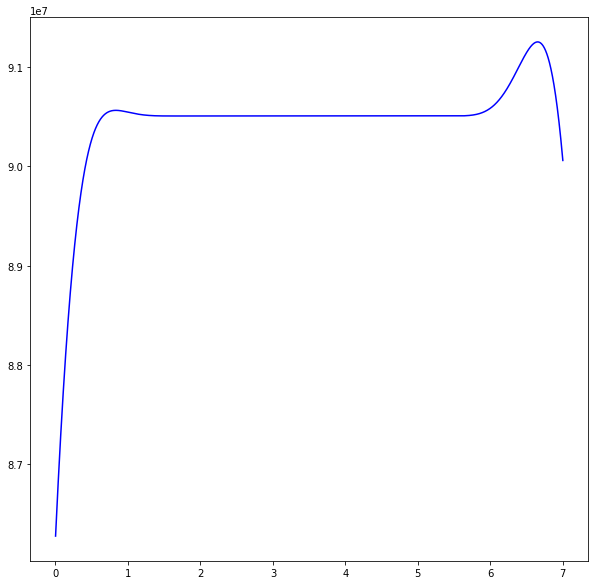

In [180]:
plt.figure(figsize=(10, 10))
plt.plot(x0, np.log(mu) + y0, 'b-')
#plt.ylim((4e6, 4.3e6))

In [170]:
np.max(y0)

10793133.39464096

In [171]:
sub_const = 10793100. #171. #100 # 260 #345000.
def density_eval_1d_cus(basis_function, base_density, coef):

    n_obs = basis_function.landmarks.shape[0]
    landmarks = basis_function.landmarks
    
    def den(x): 

        den_val = (base_density.baseden_eval_1d(x) * 
                   np.exp(- sub_const + np.sum([coef[i] * basis_function.basis_x_1d(landmarks[i])(x)
                          for i in range(n_obs)])))
        
        return den_val

    return den

In [172]:
int_result, _ = scipy.integrate.quad(
    density_eval_1d_cus(
        basis_function = basis_function, 
        base_density = base_density, 
        coef = coef_sm), 
    a = 0., 
    b = np.inf, 
    limit = 100)
int_result

5.306507554708714e-15

(-0.005, 0.97)

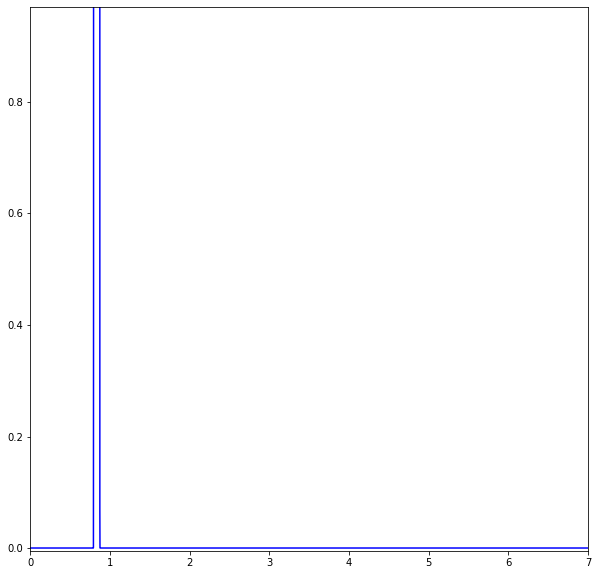

In [173]:
den_vals = mu * np.exp(y0 - sub_const) / int_result 
plt.figure(figsize = (10, 10))
plt.plot(x0, den_vals, 'b-')
plt.xlim(xlimit)
plt.ylim(ylimit)
# plt.vlines(x = 75., ymin = -1, ymax = 1)

In [174]:
file_name = f'original_denvals_scorematching_bw={basis_function.bw}_0.1_6.9_20.npy'
np.save(f'{basis_function.basisfunction_name}_basis_function/scorematching/' + file_name, 
        den_vals)

In [ ]:
bbww = 16.0
file_name = f'original_denvals_scorematching_bw={bbww}.npy'
yy0 = np.load(f'{basis_function.basisfunction_name}_basis_function/scorematching/' + file_name)
plt.figure(figsize=(10, 10))
plt.plot(x0, yy0, 'b-')
plt.ylim(ylimit)

In [ ]:
bw = 16.0
basis_function = LogisticBasisFunction(
    landmarks = landmarks,
    bw = bw)
base_density = BasedenGamma(data_waiting)

In [ ]:
batchmc_params = batch_montecarlo_params(
    mc_batch_size = 1000, 
    mc_tol = 1e-2)

nll_algo_params = negloglik_optalgoparams(
    start_pt = np.random.randn(landmarks.shape[0]).reshape(-1, 1), # -np.ones((landmarks.shape[0], 1)), 
    step_size = 0.1, 
    max_iter = 500, 
    rel_tol = 5e-2)

In [ ]:
now1 = datetime.now()

coef_lik = negloglik_finexpfam_coef(
    data = data_waiting, 
    basis_function = basis_function, 
    base_density = base_density, 
    optalgo_params = nll_algo_params, 
    batchmc_params = batchmc_params,
    batch_mc = True, 
    batch_mc_se = False, 
    print_error = True)
now2 = datetime.now()
print(now1, now2)
print(now2 - now1)

In [ ]:
file_name = f'original_coef_likelihood_bw={basis_function.bw}_unique.npy'
np.save(f'{basis_function.basisfunction_name}_basis_function/likelihood/' + file_name, 
        coef_lik)

In [ ]:
plot_params = plot_density_1d_params(x_limit = xlimit, y_limit = ylimit, plot_pts_cnt=4000)

In [ ]:
den_vals = plot_density_1d(
    data = data_waiting, 
    basis_function = basis_function, 
    base_density = base_density, 
    coef = coef_lik, 
    normalizing = True, 
    method = 'likelihood', 
    x_label = 'waiting',
    plot_kwargs = plot_params, 
    save_plot = False, 
    save_dir = None, 
    save_filename = None)

In [ ]:
file_name = f'original_denvals_likelihood_bw={basis_function.bw}_unique.npy'
np.save(f'{basis_function.basisfunction_name}_basis_function/likelihood/' + file_name, 
        den_vals['den_vals'])